## Wprowadzenie


## Preprocessing


In [1]:
from glob import glob
import os
import torch


n_images = 3000
imgs = sorted(glob(os.path.join("data", "imgs", "*.png")))[:n_images]
masks = sorted(glob(os.path.join("data", "masks", "*.png")))[:n_images]

TRAIN_RATIO = 0.7
VAL_RATIO = 0.2

train_size = int(TRAIN_RATIO * n_images)
val_size = int(VAL_RATIO * n_images)
test_size = n_images - train_size - val_size
train_size += n_images - (train_size + val_size + test_size)

files = [{"img": img, "mask": mask} for img, mask in zip(imgs, masks)]
print(len(imgs), len(masks))
train_files, val_files, test_files = torch.utils.data.random_split(
    files,
    [train_size, val_size, test_size],
)

3000 3000


## Augmentacja danych


In [2]:
from monai.transforms import (
    LoadImaged,
    Compose,
    RandRotate90d,
    ScaleIntensityd,
    Resized,
)
from monai.data import PILReader

train_transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(
                converter=lambda image: image.convert("L"), reverse_indexing=False
            ),
            dtype=torch.float,
        ),
        ScaleIntensityd(keys=["img", "mask"], minv=0, maxv=1),
        RandRotate90d(keys=["img", "mask"], prob=0.5, spatial_axes=(0, 1)),
        Resized(keys=["img", "mask"], spatial_size=(512, 512)),
    ]
)

val_transform = Compose(
    [
        LoadImaged(
            keys=["img", "mask"],
            image_only=True,
            ensure_channel_first=True,
            reader=PILReader(
                converter=lambda image: image.convert("L"), reverse_indexing=False
            ),
            dtype=torch.float,
        ),
        ScaleIntensityd(keys=["img", "mask"], minv=0, maxv=1),
        Resized(keys=["img", "mask"], spatial_size=(512, 512)),
    ]
)

## Stworzenie datasetów


In [3]:

import monai

train_dataset = monai.data.Dataset(data=train_files, transform=train_transform)
val_dataset = monai.data.Dataset(data=val_files, transform=val_transform)
test_dataset = monai.data.Dataset(data=test_files, transform=val_transform)

In [4]:
import gc

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

## Parametery


In [5]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

# from unet import UNet
from resunet import ResUNet

torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
lr = 0.001
nepochs = 400
bs = 64

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss(sigmoid=True)

## Dataloadery


In [6]:
import monai

train_dataloader = monai.data.DataLoader(
    train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=8
)
val_dataloader = monai.data.DataLoader(
    val_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=8
)
test_dataloader = monai.data.DataLoader(
    test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=8
)

## Trening


In [7]:
import torch
from tqdm import trange

import matplotlib.pyplot as plt
from pathlib import Path

train_losses = []
val_losses = []
val_interval = 2
save_interval = 10
save_dir = "model"
Path(save_dir).mkdir(exist_ok=True)

scaler = torch.GradScaler("cuda")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15, min_lr=1e-6
)

print(f"Initial GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.memory_reserved()/1024**3:.2f}GB")

for epoch in (pbar := trange(nepochs)):
    model.train()
    train_loss = 0.0
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1} - GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f}GB / {torch.cuda.memory_reserved()/1024**3:.2f}GB")
    for i, batch_data in enumerate(train_dataloader):
        img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast("cuda"):
            output = model(img)
            loss = criterion(output, mask)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        curr_loss = loss.item()
        train_loss += curr_loss
        pbar.set_description(
            f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(train_dataloader)}, loss: {curr_loss}"
        )
    train_losses.append(train_loss / len(train_dataloader))
    

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for i, batch_data in enumerate(val_dataloader):
                img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
                output = model(img)
                loss = criterion(output, mask)
                curr_loss = loss.item()
                val_loss += curr_loss
                pbar.set_description(
                    f"Epoch {epoch+1}/{nepochs}, iteration {i+1}/{len(val_dataloader)}, loss: {curr_loss}"
                )
            val_loss_mean = val_loss / len(val_dataloader)
            val_losses.append(val_loss_mean)
            scheduler.step(val_loss_mean)
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_{epoch+1}.pth"))


Initial GPU Memory: 0.01GB / 0.02GB


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1 - GPU Memory: 0.01GB / 0.02GB


Epoch 10/400, iteration 10/10, loss: 0.9917632937431335:   2%|▎         | 10/400 [01:16<48:08,  7.41s/it]

Epoch 11 - GPU Memory: 0.10GB / 5.39GB


Epoch 20/400, iteration 10/10, loss: 0.9665839672088623:   5%|▌         | 20/400 [02:27<46:46,  7.38s/it]

Epoch 21 - GPU Memory: 0.10GB / 5.39GB


Epoch 30/400, iteration 10/10, loss: 0.3295360207557678:   8%|▊         | 30/400 [03:37<43:56,  7.13s/it] 

Epoch 31 - GPU Memory: 0.10GB / 5.39GB


Epoch 40/400, iteration 10/10, loss: 0.3280673027038574:  10%|█         | 40/400 [04:45<42:50,  7.14s/it] 

Epoch 41 - GPU Memory: 0.10GB / 5.39GB


Epoch 50/400, iteration 10/10, loss: 0.3127409815788269:  12%|█▎        | 50/400 [05:55<42:56,  7.36s/it] 

Epoch 51 - GPU Memory: 0.10GB / 5.39GB


Epoch 60/400, iteration 10/10, loss: 0.29067230224609375:  15%|█▌        | 60/400 [07:05<41:17,  7.29s/it]

Epoch 61 - GPU Memory: 0.10GB / 5.39GB


Epoch 70/400, iteration 10/10, loss: 0.3004429042339325:  18%|█▊        | 70/400 [08:16<39:40,  7.21s/it] 

Epoch 71 - GPU Memory: 0.10GB / 5.39GB


Epoch 80/400, iteration 10/10, loss: 0.2788159251213074:  20%|██        | 80/400 [09:27<39:07,  7.34s/it] 

Epoch 81 - GPU Memory: 0.10GB / 5.39GB


Epoch 90/400, iteration 10/10, loss: 0.29354584217071533:  22%|██▎       | 90/400 [10:37<37:45,  7.31s/it]

Epoch 91 - GPU Memory: 0.10GB / 5.39GB


Epoch 100/400, iteration 10/10, loss: 0.2961609959602356:  25%|██▌       | 100/400 [11:49<37:00,  7.40s/it]

Epoch 101 - GPU Memory: 0.10GB / 5.39GB


Epoch 110/400, iteration 10/10, loss: 0.2789965867996216:  28%|██▊       | 110/400 [13:00<35:20,  7.31s/it] 

Epoch 111 - GPU Memory: 0.10GB / 5.39GB


Epoch 120/400, iteration 10/10, loss: 0.2755992114543915:  30%|███       | 120/400 [14:11<34:14,  7.34s/it] 

Epoch 121 - GPU Memory: 0.10GB / 5.39GB


Epoch 130/400, iteration 10/10, loss: 0.29696163535118103:  32%|███▎      | 130/400 [15:22<33:11,  7.37s/it]

Epoch 131 - GPU Memory: 0.10GB / 5.39GB


Epoch 140/400, iteration 10/10, loss: 0.2786067724227905:  35%|███▌      | 140/400 [16:33<31:41,  7.31s/it] 

Epoch 141 - GPU Memory: 0.10GB / 5.39GB


Epoch 150/400, iteration 10/10, loss: 0.2712675929069519:  38%|███▊      | 150/400 [17:44<30:12,  7.25s/it] 

Epoch 151 - GPU Memory: 0.10GB / 5.39GB


Epoch 160/400, iteration 10/10, loss: 0.27856481075286865:  40%|████      | 160/400 [18:54<29:19,  7.33s/it]

Epoch 161 - GPU Memory: 0.10GB / 5.39GB


Epoch 170/400, iteration 10/10, loss: 0.27920210361480713:  42%|████▎     | 170/400 [20:04<27:45,  7.24s/it]

Epoch 171 - GPU Memory: 0.10GB / 5.39GB


Epoch 173/400, iteration 1/33, loss: 0.20179976522922516:  43%|████▎     | 172/400 [20:21<26:58,  7.10s/it] 


KeyboardInterrupt: 

In [16]:
import numpy as np
print(np.array(val_losses))

[0.99556711 0.99531293 0.9946738  0.99321891 0.99100792 0.98796493
 0.98367767 0.97897974 0.97182116 0.96349177 0.95307976 0.71740304
 0.459577   0.36898557 0.34133479 0.32735464 0.33179884 0.31844151
 0.31282169 0.29815374 0.29615709 0.29639757 0.2928995  0.2806009
 0.2784954  0.27863702 0.27648825 0.27795788 0.27287309 0.26600366
 0.2705759  0.27200665 0.26211634 0.25893761 0.256692   0.25684141
 0.26004679 0.25407833 0.2552964  0.24668234 0.25513871 0.24796171
 0.24516112 0.2473149  0.24411647 0.24768464 0.25214846 0.23992105
 0.24917571 0.25158523 0.24595519 0.23583806 0.24361341 0.24492862
 0.24685599 0.23894587 0.24049236 0.24221278 0.24581091 0.2472468
 0.24538449 0.24996246 0.24490336 0.24272051 0.24309777 0.23920416
 0.23909928 0.24324145 0.23250579 0.2405327  0.23668899 0.23809927
 0.23470739 0.23553924 0.23427282 0.23439849 0.23755342 0.23720545
 0.24269091 0.23957441 0.23561122 0.23505291 0.23720435 0.23965968
 0.24039682 0.2348036 ]


In [17]:
print(np.array(train_losses))

[0.99646238 0.99596975 0.99580747 0.99567786 0.99550748 0.99522394
 0.9948104  0.99413939 0.99324888 0.99222206 0.9910262  0.98974757
 0.98795625 0.98593292 0.98384586 0.98140371 0.97861385 0.97533923
 0.97203023 0.96787535 0.96333904 0.95883283 0.95289987 0.86900385
 0.64573885 0.53355886 0.44744455 0.40476315 0.38454263 0.36465656
 0.35703715 0.34460855 0.32911774 0.3277789  0.32303975 0.31704025
 0.3046585  0.29907259 0.30230189 0.29863593 0.29169635 0.29244346
 0.28418921 0.28065712 0.27799858 0.28523498 0.27554481 0.26905664
 0.26864036 0.26891293 0.27059054 0.26636637 0.26664638 0.26124396
 0.25837665 0.25700003 0.25549685 0.25420253 0.25927375 0.25675369
 0.24675959 0.24670596 0.25175061 0.24598262 0.25031566 0.24887715
 0.24281917 0.23744615 0.24604488 0.24203103 0.2408572  0.23863275
 0.23800628 0.23372924 0.2364384  0.23419975 0.23819104 0.23405966
 0.23175224 0.22239551 0.22272089 0.22395412 0.22093232 0.22902798
 0.22643826 0.21846069 0.22132756 0.22424601 0.21929836 0.2204

## Wykresy strat


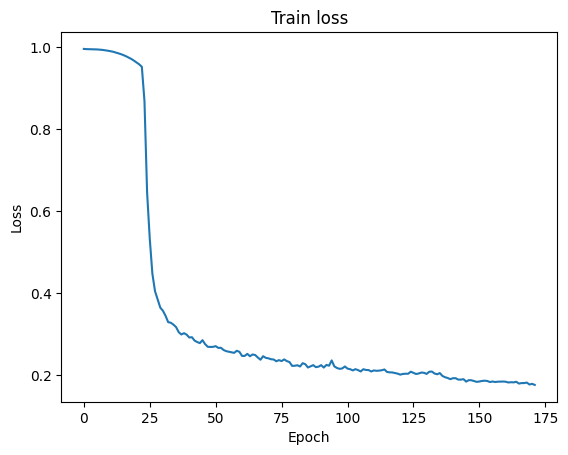

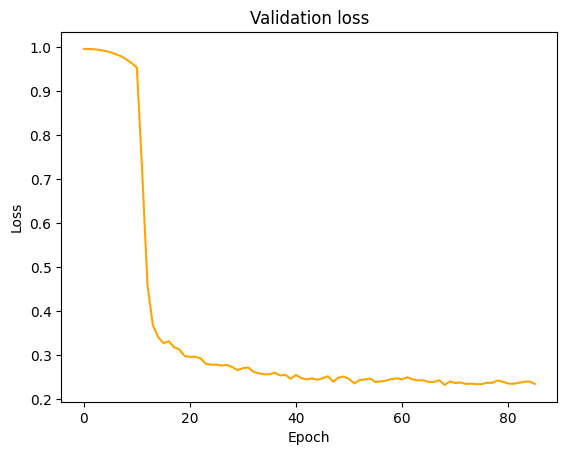

In [18]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="train")
plt.title("Train loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("train_loss.png")
plt.show()
plt.plot(val_losses, label="val", color="orange")
plt.title("Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.savefig("val_loss.png")
plt.show()

In [19]:
filename = "./model/model_172.pth"
torch.save(model.state_dict(), filename)

## Testowanie


In [22]:
import torch
from monai.networks.nets import UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# filename = "./models/best-model/model-monai-400epoch-3000img-256x256.pth"
filename = "./model/monai-400epoch-3000img-512x512/model_172.pth"

model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load(filename))

<All keys matched successfully>

Average iou: 0.68
Average dice coefficient: 0.77
Average recall: 0.80
Average precision: 0.78


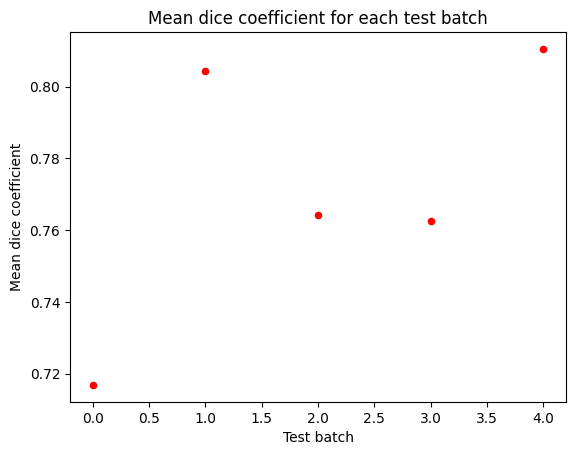

In [23]:
from monai.metrics import compute_iou, compute_dice
import numpy as np

from util import recall, precision

dices = []
ious = []
recalls = []
precisions = []

model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(test_dataloader):
        img, mask = batch_data["img"].to(device), batch_data["mask"].to(device)
        output = torch.sigmoid(model(img))
        torch.where(
            output > 0.5,
            torch.tensor([1.0], device=device),
            torch.tensor([0.0], device=device),
            out=output,
        )
        torch.where(
            mask > 0.0,
            torch.tensor([1.0], device=device),
            torch.tensor([0.0], device=device),
            out=mask,
        )
        dice_coeff = compute_dice(output, mask, ignore_empty=False).mean(dim=0)
        iou = compute_iou(output, mask, ignore_empty=False).mean(dim=0)
        r = recall(mask, output).mean()
        p = precision(mask, output).mean()
        dices.append(dice_coeff.item())
        ious.append(iou.item())
        recalls.append(r.item())
        precisions.append(p.item())
print(f"Average iou: {(sum(ious) / len(ious)):.2f}")
print(f"Average dice coefficient: {(sum(dices) / len(dices)):.2f}")
print(f"Average recall: {(sum(recalls) / len(recalls)):.2f}")
print(f"Average precision: {(sum(precisions) / len(precisions)):.2f}")
plt.scatter(np.arange(len(dices)), dices, s=20, c="red")
plt.xlabel("Test batch")
plt.ylabel("Mean dice coefficient")
plt.title("Mean dice coefficient for each test batch")
plt.savefig("dice_metric.png")

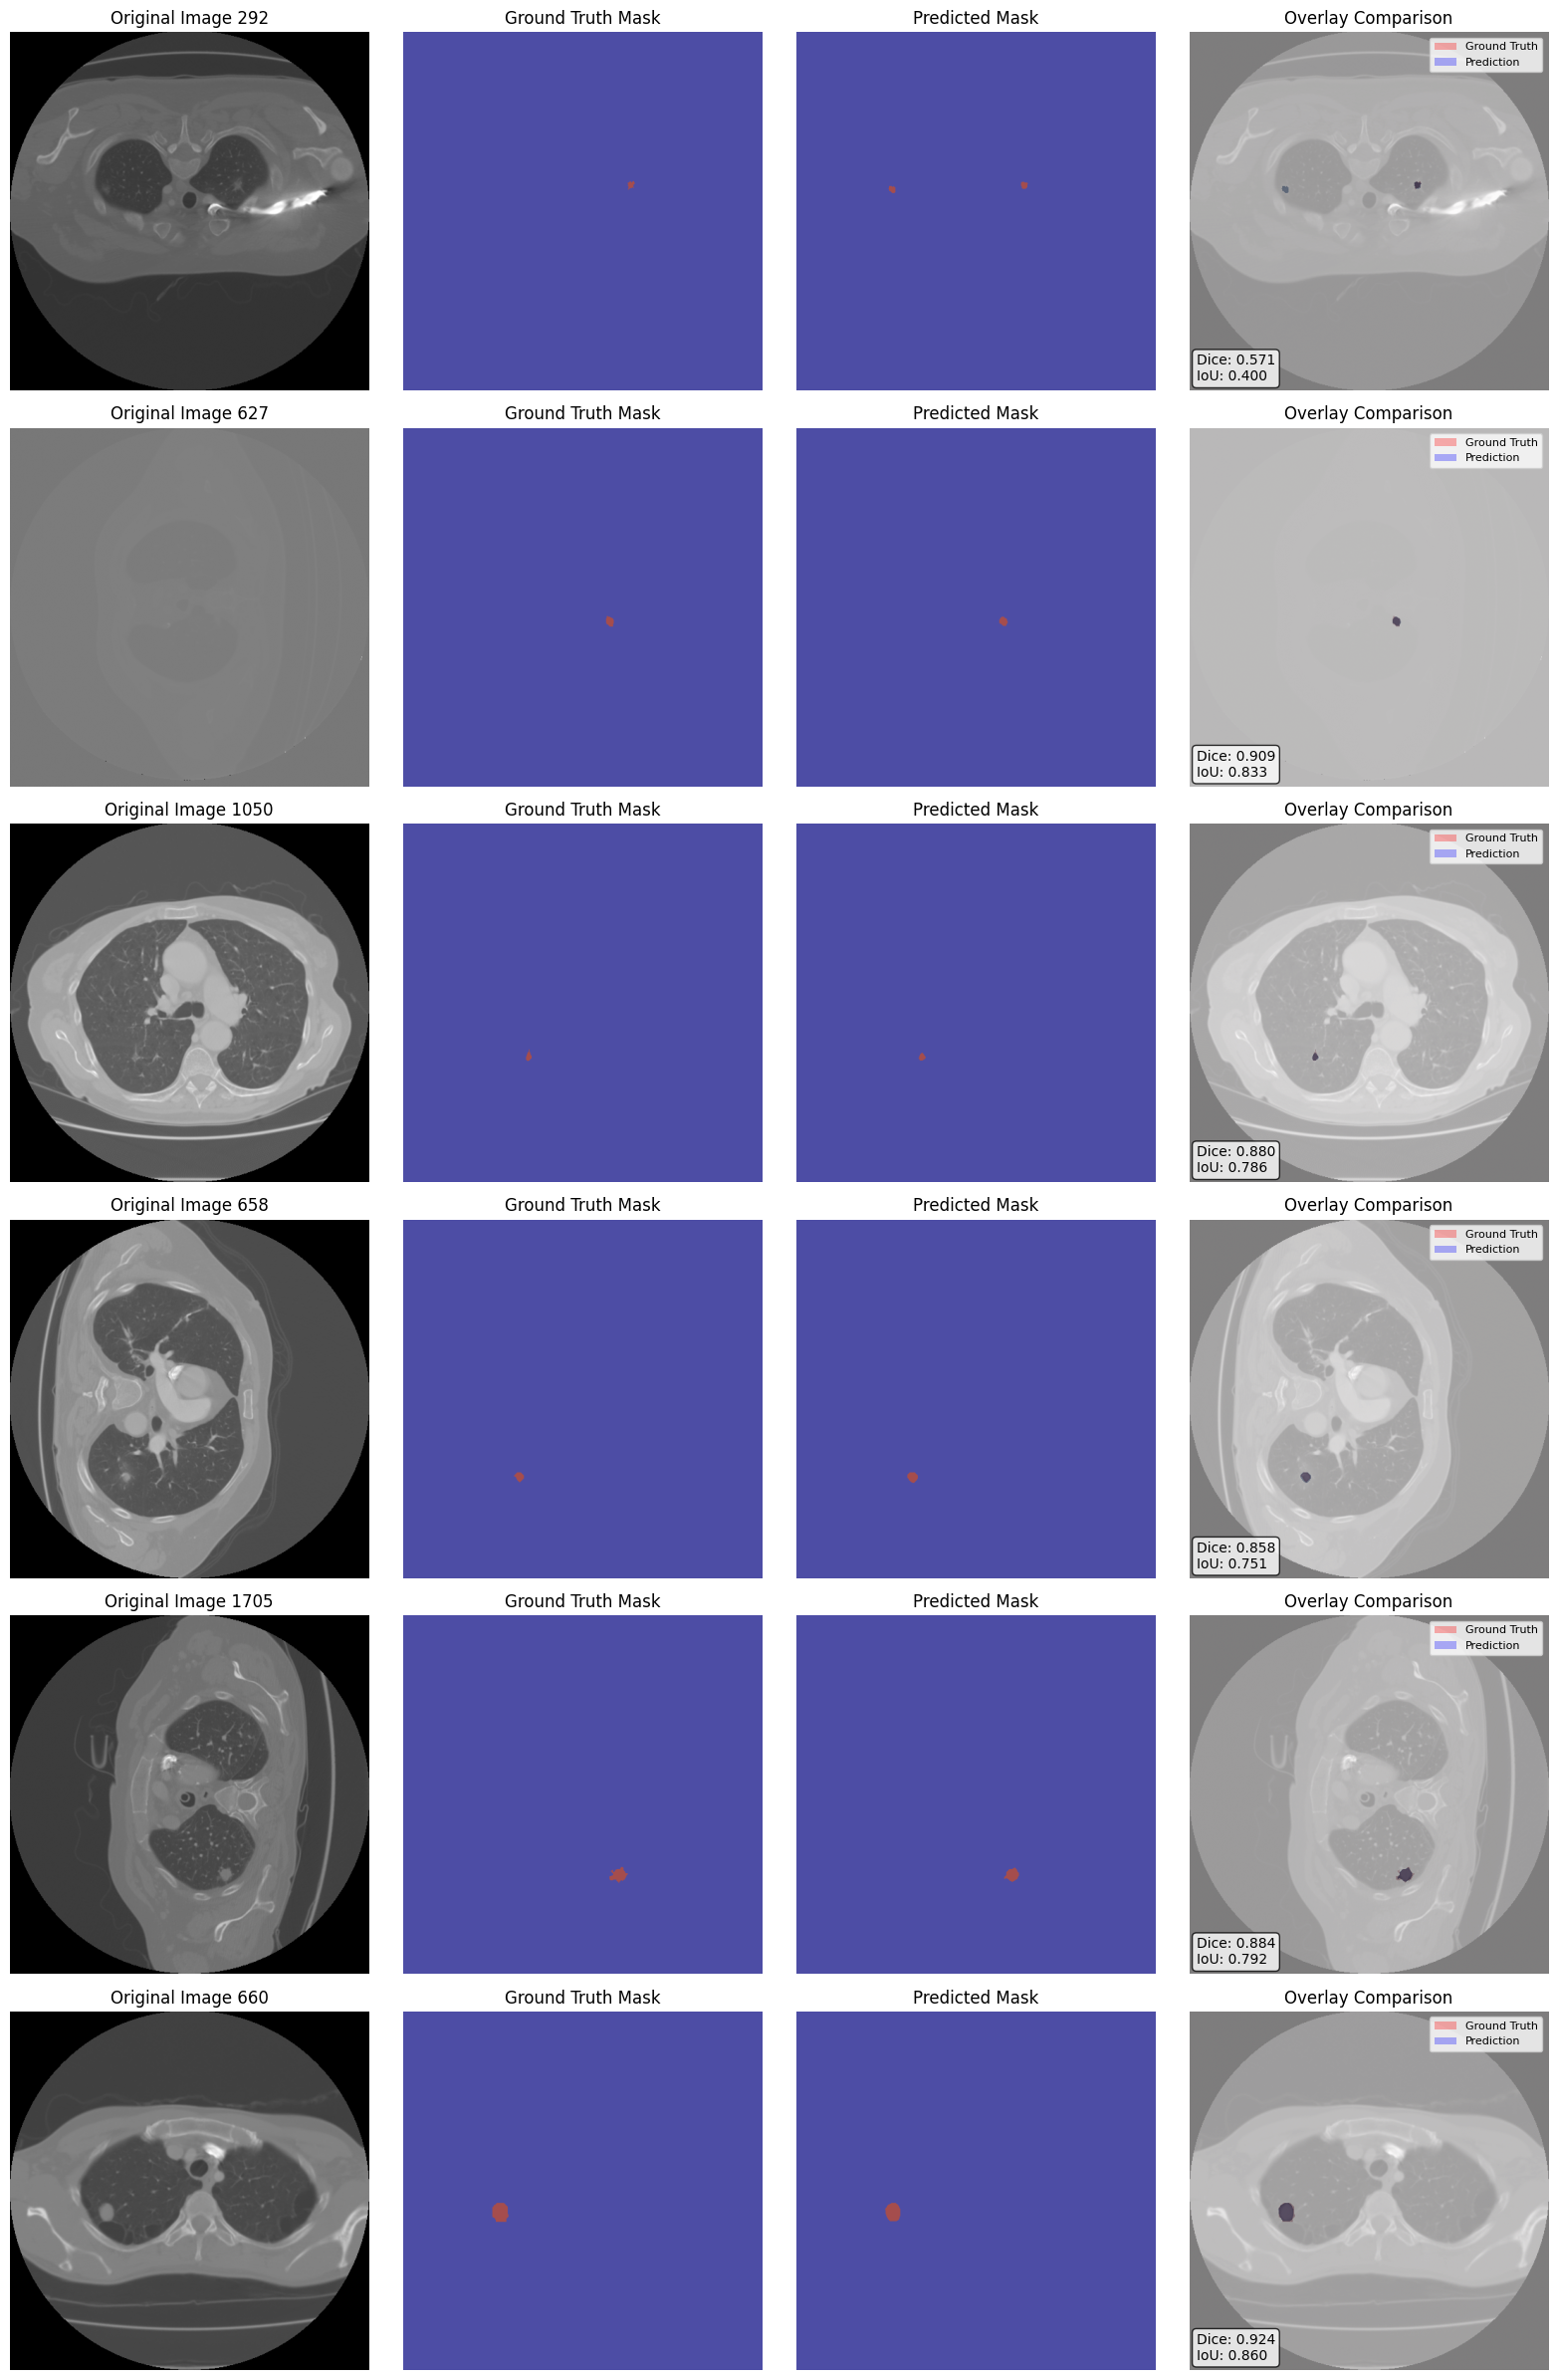

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.patches import Rectangle

def visualize_predictions(model, dataset, device, num_samples=6):
    model.eval()
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            sample = dataset[sample_idx]
            img = sample["img"].unsqueeze(0).to(device)
            mask = sample["mask"].squeeze().cpu().numpy()
            
            output = torch.sigmoid(model(img))
            prediction = (output > 0.5).float()
            prediction = prediction.squeeze().cpu().numpy()
            
            img_display = img.squeeze().cpu().numpy()
            
            axes[idx, 0].imshow(img_display, cmap='gray')
            axes[idx, 0].set_title(f'Original Image {sample_idx}')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(mask, cmap='jet', alpha=0.7)
            axes[idx, 1].set_title('Ground Truth Mask')
            axes[idx, 1].axis('off')
            
            axes[idx, 2].imshow(prediction, cmap='jet', alpha=0.7)
            axes[idx, 2].set_title('Predicted Mask')
            axes[idx, 2].axis('off')
            
            axes[idx, 3].imshow(img_display, cmap='gray')
            axes[idx, 3].imshow(mask, cmap='Reds', alpha=0.3, label='Ground Truth')
            axes[idx, 3].imshow(prediction, cmap='Blues', alpha=0.3, label='Prediction')
            axes[idx, 3].set_title('Overlay Comparison')
            axes[idx, 3].axis('off')
            
            red_patch = Rectangle((0, 0), 1, 1, fc="red", alpha=0.3)
            blue_patch = Rectangle((0, 0), 1, 1, fc="blue", alpha=0.3)
            axes[idx, 3].legend([red_patch, blue_patch], 
                              ['Ground Truth', 'Prediction'], 
                              loc='upper right', fontsize=8)
            
            dice = compute_dice(
                torch.tensor(prediction).unsqueeze(0).unsqueeze(0), 
                torch.tensor(mask).unsqueeze(0).unsqueeze(0), 
                ignore_empty=False
            ).item()
            
            iou = compute_iou(
                torch.tensor(prediction).unsqueeze(0).unsqueeze(0), 
                torch.tensor(mask).unsqueeze(0).unsqueeze(0), 
                ignore_empty=False
            ).item()
            
            axes[idx, 3].text(0.02, 0.02, f'Dice: {dice:.3f}\nIoU: {iou:.3f}', 
                            transform=axes[idx, 3].transAxes, 
                            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                            fontsize=10, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.savefig('model_predictions_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def detailed_comparison(model, dataset, device, sample_idx=None):
    model.eval()
    
    if sample_idx is None:
        sample_idx = random.randint(0, len(dataset)-1)
    
    sample = dataset[sample_idx]
    img = sample["img"].unsqueeze(0).to(device)
    mask = sample["mask"].squeeze().cpu().numpy()
    
    with torch.no_grad():
        output = torch.sigmoid(model(img))
        prediction = (output > 0.5).float()
        prediction = prediction.squeeze().cpu().numpy()
        
        prob_map = output.squeeze().cpu().numpy()
    
    img_display = img.squeeze().cpu().numpy()
    
    difference = np.abs(mask - prediction)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    axes[0, 0].imshow(img_display, cmap='gray')
    axes[0, 0].set_title(f'Original Image (Sample {sample_idx})', fontsize=14)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img_display, cmap='gray')
    axes[0, 1].imshow(mask, cmap='Reds', alpha=0.6)
    axes[0, 1].set_title('Ground Truth Overlay', fontsize=14)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_display, cmap='gray')
    axes[0, 2].imshow(prediction, cmap='Blues', alpha=0.6)
    axes[0, 2].set_title('Prediction Overlay', fontsize=14)
    axes[0, 2].axis('off')
    
    im1 = axes[1, 0].imshow(prob_map, cmap='hot', vmin=0, vmax=1)
    axes[1, 0].set_title('Probability Map', fontsize=14)
    axes[1, 0].axis('off')
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    comparison = np.zeros((mask.shape[0], mask.shape[1], 3))
    comparison[:, :, 0] = mask  # Red channel for ground truth
    comparison[:, :, 2] = prediction  # Blue channel for prediction
    comparison[:, :, 1] = np.maximum(mask, prediction) * 0.5  # Green where they overlap
    
    axes[1, 1].imshow(comparison)
    axes[1, 1].set_title('Side-by-side (Red=GT, Blue=Pred, Purple=Overlap)', fontsize=14)
    axes[1, 1].axis('off')
    
    im2 = axes[1, 2].imshow(difference, cmap='Reds')
    axes[1, 2].set_title('Difference Map', fontsize=14)
    axes[1, 2].axis('off')
    plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
    
    dice = compute_dice(
        torch.tensor(prediction).unsqueeze(0).unsqueeze(0), 
        torch.tensor(mask).unsqueeze(0).unsqueeze(0), 
        ignore_empty=False
    ).item()
    
    iou = compute_iou(
        torch.tensor(prediction).unsqueeze(0).unsqueeze(0), 
        torch.tensor(mask).unsqueeze(0).unsqueeze(0), 
        ignore_empty=False
    ).item()
    
    fig.suptitle(f'Detailed Analysis - Dice: {dice:.4f}, IoU: {iou:.4f}', fontsize=16)
    
    plt.tight_layout()
    plt.savefig(f'detailed_comparison_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return dice, iou

visualize_predictions(model, train_dataset, device, num_samples=6)

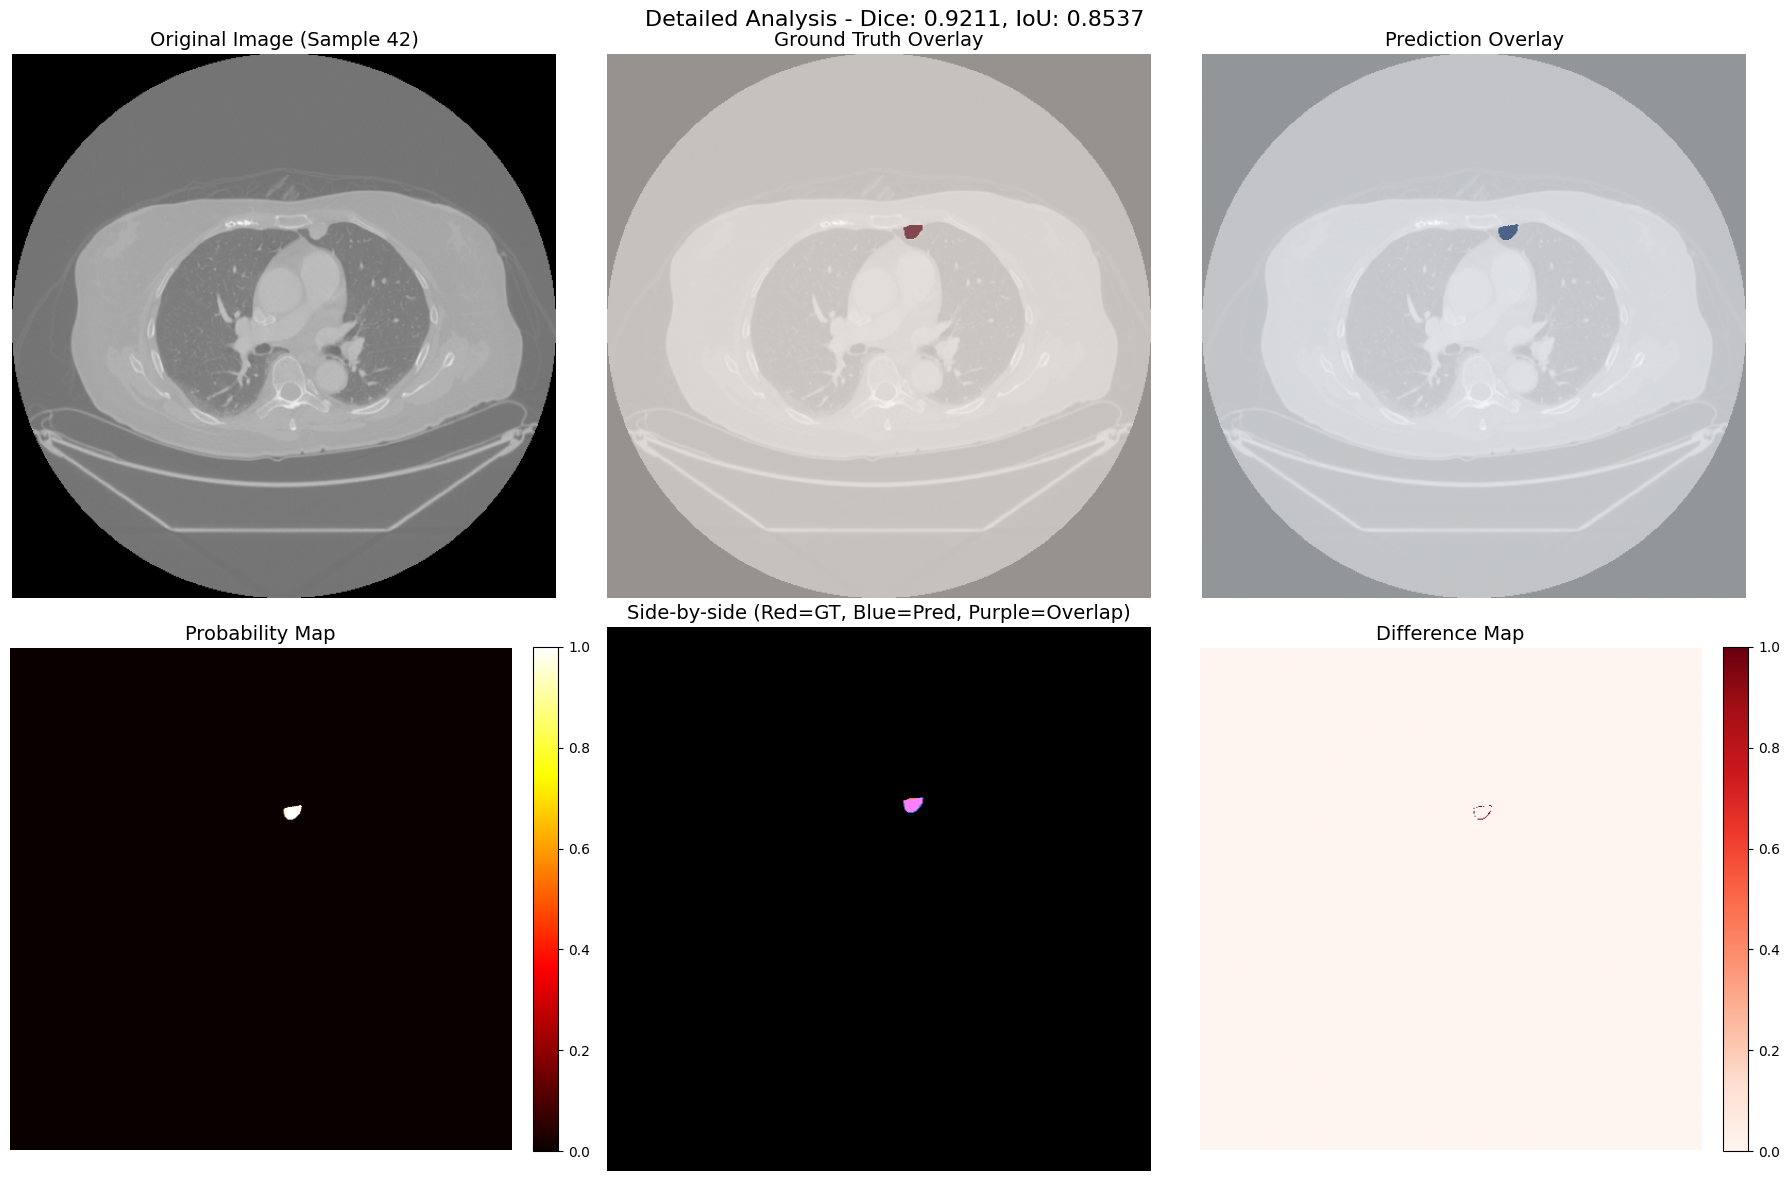

In [25]:
dice, iou = detailed_comparison(model, train_dataset, device, sample_idx=42)